<h1> Um die Funktionalität des Nootebooks zu gewährleisten, dürfen die Codezeilen NICHT Ausgeführt werden!</h1>

In [299]:
# 🧩 Zelle 1: Alle Importe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import timedelta
import psycopg2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import dis
from statsmodels.tsa.seasonal import seasonal_decompose


In [227]:
# 🔌 Zelle 2: Verbindung zur PostgreSQL-Datenbank
DB_PARAMS = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "Datacraft",
    "dbname": "redezeit",
}


def db_connect():
    try:
        conn = psycopg2.connect(**DB_PARAMS)
        print("✅ Verbindung zur Datenbank erfolgreich!")
        return conn
    except Exception as e:
        print("❌ Fehler bei der DB-Verbindung:", e)


conn = db_connect()

✅ Verbindung zur Datenbank erfolgreich!


In [228]:
# 📥 Zelle 3: Daten aus den DB-Tabellen in DataFrames laden
def load_table(name):
    return pd.read_sql(f'SELECT * FROM "{name}"', conn)


df_landingpage = load_table("landing_page_views")
df_user_behaviors = load_table("user_sessions")
df_what_did_user_do = load_table("user_events")
df_where_did_they_come_from = load_table("traffic_sources")
df_what_devices_used = load_table("device_usage")
df_where_new_visitors_come_from = load_table("traffic_source_chart")
df_who_was_visiting = load_table("daily_visitors_chart")

## Überblick über die Daten und erste Analysen

Bevor wir richtig loslegen, verschaffen wir uns einen kurzen Überblick:  
Der folgende Code gibt aus, wie viele Zeilen und Spalten die verschiedenen Datentabellen enthalten. Das zeigt uns direkt, mit welchen Datenmengen wir arbeiten. Es gibt z. B. Infos zur Startseite, zum Nutzerverhalten, zu den verwendeten Geräten und zur Herkunft der Besucher*innen.

---

### Wer war auf der Seite? – Verteilung nach Geschlecht

Im ersten Diagramm schauen wir uns an, **wie viele Besucher welcher Geschlechtskategorie** zugeordnet wurden.  
Die Daten stammen aus der Tabelle `df_who_was_visiting` und werden nach der Spalte `kategorie` (z. B. männlich, weiblich, unbekannt) gruppiert. Die Werte aus der Spalte `wert` geben an, wie viele Personen jeweils gezählt wurden.

Das Ergebnis ist ein Balkendiagramm: Es zeigt, welche Kategorie am häufigsten vorkommt.  

---

### Mit welchen Geräten wurde die Seite besucht?

Jetzt geht's um Technik: **Welche Gerätetypen** wurden am häufigsten verwendet, um die Seite zu besuchen?  
Dazu schauen wir uns die Tabelle `df_what_devices_used` an und summieren wieder die Werte aus der Spalte `wert` – gruppiert nach `kategorie` (z. B. Smartphone, Desktop, Tablet).

Das daraus entstehende Balkendiagramm gibt einen schnellen Eindruck davon, ob die Website eher mobil oder vom PC aus genutzt wurde.

---

### Woher kamen die neuen Leute? – Top 3 Kanäle

Jetzt wird's spannend fürs Marketing: Aus welchen **Quellen kamen neue Besucher** auf die Website?

Wir gruppieren hier die Tabelle `df_where_new_visitors_come_from` nach der Besuchsquelle (`kategorie`) und zählen die Sitzungen (`wert`). Anschließend zeigen wir die **Top 3 Kanäle** in einem Diagramm – also die drei häufigsten Einstiegsquellen für neue Nutzer.

Das hilft zu verstehen, **welche Kanäle am besten funktionieren** – z. B. Google Ads, Social Media, Direktaufrufe usw.  

---

### Was machen die Leute eigentlich auf der Website?

In diesem Diagramm schauen wir uns an, welche **Aktionen Besucher auf der Seite am häufigsten durchgeführt haben** – also z. B. auf einen Button geklickt, etwas abgespielt oder ein Formular gesendet.

Die Tabelle `df_what_did_user_do` enthält dafür Eventnamen (`name_des_events`) und die Anzahl aktiver Nutzer (`aktive_nutzer`) pro Event.  
Wir summieren und sortieren die Werte und zeigen die **Top 5 Aktionen** in einem Balkendiagramm.

So lässt sich herausfinden, welche Interaktionen besonders beliebt sind – also was auf der Seite tatsächlich *passiert*.

---

### Gibt’s Zusammenhänge zwischen den Zahlen? – Korrelationsanalyse

Zum Schluss gibt es noch einen Heatmap-Plot, der die **Zusammenhänge (Korrelationen)** zwischen verschiedenen Kennzahlen zeigt – z. B.:

- Seitenaufrufe  
- Anzahl Nutzer insgesamt  
- Absprungrate (wie viele springen direkt wieder ab)  
- Verweildauer in Sekunden  
- Seiten pro Sitzung  

Eine Korrelation von +1 bedeutet: „Je mehr A, desto mehr B.“  
Eine Korrelation von –1 bedeutet: „Je mehr A, desto weniger B.“  
Ein Wert um 0 bedeutet: „Kein klarer Zusammenhang.“

Die Heatmap hilft uns also, Muster und Beziehungen in den Nutzungsdaten zu erkennen – zum Beispiel, ob längere Verweildauer mit niedrigeren Absprungraten zusammenhängt.

---

## Auswertung der wichtigsten Kennzahlen

### Besucher nach Geschlecht

Die meisten Besucher der Website sind weiblich (`female`), mit insgesamt **7.060** Personen. Männliche Besucher (`male`) machen mit **1.505** einen deutlich kleineren Anteil aus.  
Das zeigt, dass die Seite überwiegend von Frauen genutzt wird, oder das Frauen zumindest häufier ihr Geschlecht mit angegeben haben.

---

### Besucher nach Gerätetyp

Die Besucher greifen fast gleich häufig über **Desktop** (74.594) und **Mobile** Geräte (71.715) auf die Website zu.  
Tablet (2.057) und Smart TV (7) spielen nur eine sehr kleine Rolle.  
Das bedeutet, dass die Seite sowohl für Desktop- als auch für mobile Nutzung optimiert sein sollte.

---

### Top 3 Herkunftskanäle neuer Besucher

Die meisten neuen Besucher kommen über **Google** mit 29.487 Sitzungen.  
Direkte Zugriffe `(direct)` folgen mit 9.380 Sitzungen.  
Auf Platz 3 liegt die Domain `kompetenznetz-einsamkeit.de` mit 1.897 Sitzungen.  
Diese Kanäle sind also besonders wichtig für den Website-Traffic.

---

### Top 5 Nutzeraktionen auf der Website

Die am häufigsten ausgeführten Aktionen sind:  
- `Checked` mit 12.828 aktiven Nutzer,  
- gefolgt von `Website` mit 7.329,  
- `Email` mit 2.961,  
- `Phone` mit 1.137,  
- und `Image` mit 88 Nutzer.

Diese Daten zeigen, welche Interaktionen für die Besucher besonders relevant sind.

---

### Zusammenhänge zwischen Nutzerkennzahlen (Korrelationsmatrix)

- **Seitenaufrufe** und **Absprungrate** stehen negativ korreliert (−0,38): Mehr Seitenaufrufe gehen tendenziell mit einer geringeren Absprungrate einher.  
- Zwischen **Verweildauer (Zeit in Sekunden)** und **Seiten pro Sitzung** besteht eine moderate positive Korrelation (0,56): Längere Sitzungen gehen mit mehr aufgerufenen Seiten einher.  
- Die **Absprungrate** korreliert leicht negativ mit der **Verweildauer** (−0,20), was sinnvoll ist: Je kürzer die Verweildauer, desto eher springen Nutzer ab.  
- Die Korrelationen zwischen **Nutzer insgesamt** und anderen Kennzahlen sind eher schwach.

Diese Zusammenhänge helfen, das Nutzerverhalten besser zu verstehen und gezielt zu optimieren.

---


Landingpage: (19173, 4)
User Behaviors: (1147, 7)
What Did User Do: (19321, 6)
Where Did They Come From: (8778, 6)
What Devices Used: (2852, 3)
Where New Visitors Come From: (8476, 3)
Who Was Visiting: (632, 3)


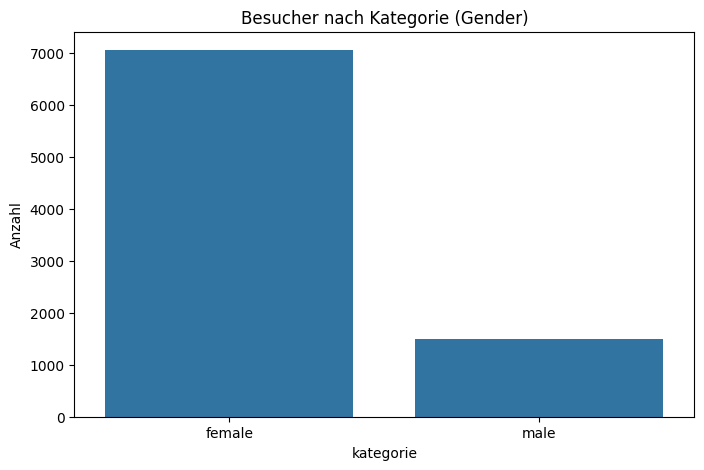

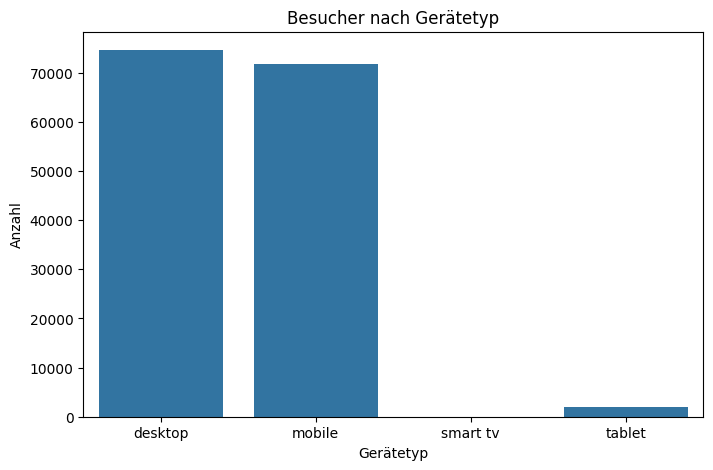

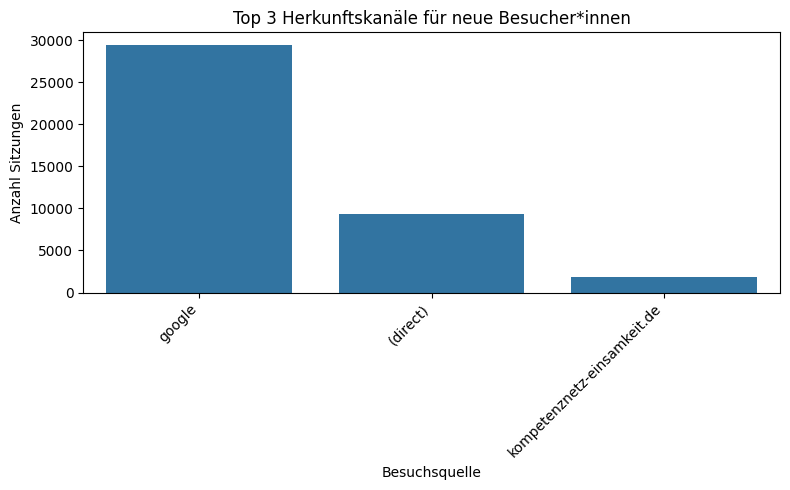

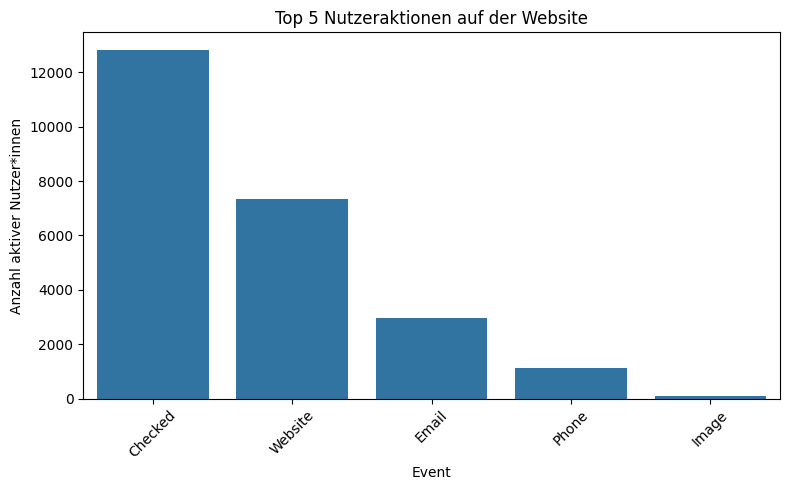

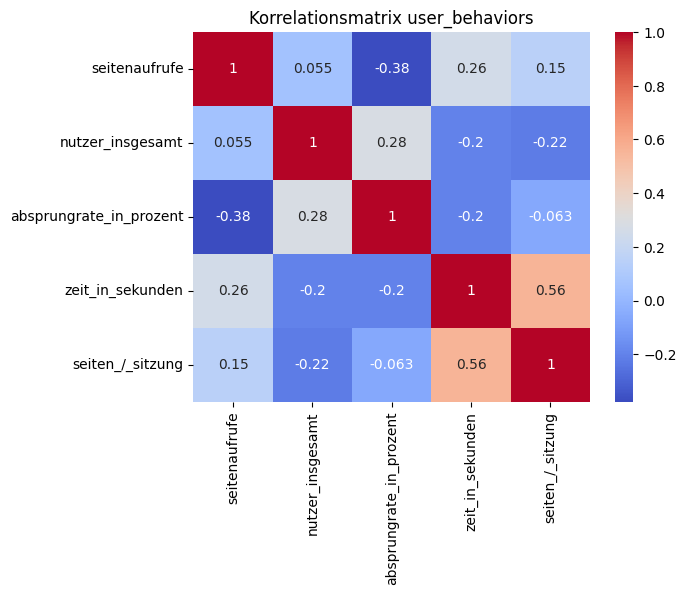

In [ ]:
# Überblick über Tabellen
print("Landingpage:", df_landingpage.shape)
print("User Behaviors:", df_user_behaviors.shape)
print("What Did User Do:", df_what_did_user_do.shape)
print("Where Did They Come From:", df_where_did_they_come_from.shape)
print("What Devices Used:", df_what_devices_used.shape)
print("Where New Visitors Come From:", df_where_new_visitors_come_from.shape)
print("Who Was Visiting:", df_who_was_visiting.shape)

# Verteilung Besucher nach Kategorie (Gender)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_who_was_visiting.groupby("kategorie")["wert"].sum().reset_index(),
    x="kategorie",
    y="wert",
)
plt.title("Besucher nach Kategorie (Gender)")
plt.ylabel("Anzahl")
plt.show()

# Verteilung nach Gerätetypen
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_what_devices_used.groupby("kategorie")["wert"].sum().reset_index(),
    x="kategorie",
    y="wert",
)
plt.title("Besucher nach Gerätetyp")
plt.ylabel("Anzahl")
plt.xlabel("Gerätetyp")
plt.show()

# Herkunft neuer Besucher*innen – Top 5-Kanäle anhand der Sitzungen
top_sources = (
    df_where_new_visitors_come_from.groupby("kategorie")["wert"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=top_sources, x="kategorie", y="wert")
plt.title("Top 3 Herkunftskanäle für neue Besucher*innen")
plt.ylabel("Anzahl Sitzungen")
plt.xlabel("Besuchsquelle")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Häufigste Nutzeraktionen
top_events = (
    df_what_did_user_do.groupby("name_des_events")["aktive_nutzer"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(data=top_events, x="name_des_events", y="aktive_nutzer")
plt.title("Top 5 Nutzeraktionen auf der Website")
plt.ylabel("Anzahl aktiver Nutzer*innen")
plt.xlabel("Event")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Korrelationen bei user_behaviors (numerisch)
num_cols = [
    "seitenaufrufe",
    "nutzer_insgesamt",
    "absprungrate_in_prozent",
    "zeit_in_sekunden",
    "seiten_/_sitzung",
]
sns.heatmap(df_user_behaviors[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatrix user_behaviors")

plt.show()

In [ ]:
# Plotwerte als Tabellen
# 1. Besucher*innen nach Geschlecht - Summen pro Kategorie
display("Besucher*innen nach Geschlecht (Summen):")
display(df_who_was_visiting.groupby("kategorie")["wert"].sum())

# 2. Besucher*innen nach Gerätetyp - Summen pro Kategorie
display("Besucher*innen nach Gerätetyp (Summen):")
display(df_what_devices_used.groupby("kategorie")["wert"].sum())

# 3. Top 3 Herkunftskanäle neuer Besucher*innen mit Sitzungen
display("Top 3 Herkunftskanäle für neue Besucher*innen:")
display(
    df_where_new_visitors_come_from.groupby("kategorie")["wert"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

# 4. Top 5 Nutzeraktionen nach aktiven Nutzer*innen
display("Top 5 Nutzeraktionen auf der Website:")
display(
    df_what_did_user_do.groupby("name_des_events")["aktive_nutzer"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# 5. Korrelationsmatrix numerischer Spalten (rund auf 2 Dezimalstellen)
display("Korrelationsmatrix user_behaviors:")
display(
    df_user_behaviors[
        [
            "seitenaufrufe",
            "nutzer_insgesamt",
            "absprungrate_in_prozent",
            "zeit_in_sekunden",
            "seiten_/_sitzung",
        ]
    ]
    .corr()
    .round(2)
)

'Besucher*innen nach Geschlecht (Summen):'

kategorie
female    7060
male      1505
Name: wert, dtype: int64

'Besucher*innen nach Gerätetyp (Summen):'

kategorie
desktop     74594
mobile      71715
smart tv        7
tablet       2057
Name: wert, dtype: int64

'Top 3 Herkunftskanäle für neue Besucher*innen:'

kategorie
google                         29487
(direct)                        9380
kompetenznetz-einsamkeit.de     1897
Name: wert, dtype: int64

'Top 5 Nutzeraktionen auf der Website:'

name_des_events
Checked    12828
Website     7329
Email       2961
Phone       1137
Image         88
Name: aktive_nutzer, dtype: int64

'Korrelationsmatrix user_behaviors:'

,seitenaufrufe,nutzer_insgesamt,absprungrate_in_prozent,zeit_in_sekunden,seiten_/_sitzung
seitenaufrufe,1.00,0.05,-0.38,0.26,0.15
nutzer_insgesamt,0.05,1.00,0.28,-0.20,-0.22
absprungrate_in_prozent,-0.38,0.28,1.00,-0.20,-0.06
zeit_in_sekunden,0.26,-0.20,-0.20,1.00,0.56
seiten_/_sitzung,0.15,-0.22,-0.06,0.56,1.00


<h1>Aggregation der Verhaltensdaten pro Tag</h1>
<p>In diesem Codeblock fassen wir die Nutzerdaten aus der Tabelle <code>user_behaviors</code> auf Tagesbasis zusammen. Das bedeutet, wir berechnen für jeden einzelnen Tag folgende Kennzahlen:</p>
<ul>
  <li><strong>Seitenaufrufe:</strong> Die Gesamtzahl der aufgerufenen Seiten an diesem Tag.</li>
  <li><strong>Nutzer Insgesamt:</strong> Die Summe aller Nutzer, die an diesem Tag die Plattform genutzt haben.</li>
  <li><strong>Durchschnittliche Verweildauer:</strong> Die mittlere Zeit (in Sekunden), die Nutzer auf der Seite verbracht haben.</li>
  <li><strong>Durchschnittliche Absprungrate:</strong> Der durchschnittliche Anteil an Besuchern, die die Seite sofort wieder verlassen haben.</li>
  <li><strong>Seiten pro Sitzung:</strong> Die durchschnittliche Anzahl der Seiten, die ein Nutzer pro Besuch angeschaut hat.</li>
</ul>
<p>Durch diese Aggregation gewinnen wir eine kompakte Tagesübersicht, die es ermöglicht, Trends und Muster im Nutzerverhalten über die Zeit besser zu erkennen. Beispielsweise können wir so Tage mit besonders hohem Traffic oder mit besonders langer Verweildauer identifizieren.</p>

<h1>Was man sieht und was es bedeutet:</h1>
<ul>
  <li>Die Tabelle zeigt eine erste Zusammenfassung der wichtigsten Verhaltenskennzahlen pro Tag.</li>
  <li>Diese aggregierten Werte bilden die Grundlage, um zeitliche Veränderungen im Nutzerverhalten zu analysieren, wie z.B. ob es bestimmte Wochentage mit besonders vielen Besuchern gibt oder wie sich die Verweildauer über die Zeit verändert.</li>
  <li>Diese Informationen sind wichtig, um saisonale Effekte, Spitzenzeiten oder potenzielle Problemzeiten (z.B. hohe Absprungrate) zu erkennen und darauf reagieren zu können.</li>
</ul>


In [196]:
# Aggregation pro Tag: Seitenaufrufe & durchschnittliche Verweildauer

daily_agg = (
    df_user_behaviors.groupby("datum")
    .agg(
        {
            "seitenaufrufe": "sum",
            "nutzer_insgesamt": "sum",
            "zeit_in_sekunden": "mean",
            "absprungrate_in_prozent": "mean",
            "seiten_/_sitzung": "mean",
        }
    )
    .reset_index()
)

display(daily_agg.sort_values(by="datum", ascending=False))

,datum,seitenaufrufe,nutzer_insgesamt,zeit_in_sekunden,absprungrate_in_prozent,seiten_/_sitzung
1146,2025-07-01,59,54,67.0,70.69,1.0
1145,2025-06-30,88,71,79.0,42.70,0.0
1144,2025-06-29,89,60,124.0,27.54,1.0
1143,2025-06-28,81,72,60.0,40.51,1.0
1142,2025-06-27,70,62,57.0,39.71,1.0
...,...,...,...,...,...,...
4,2022-03-16,114,2,93.0,100.00,57.0
3,2022-03-15,1,2,356.0,100.00,276.0
2,2022-03-14,610,3,389.0,0.00,67.0
1,2022-03-13,9,2,9.0,0.00,4.0


## Clustering der Tagesdaten: Nutzergruppen und Verhaltensmuster

### Was passiert im Code?

Wir wollen die Tagesdaten der Website-Besucher besser verstehen – und zwar durch **Clustering**, also das automatische Gruppieren von ähnlichen Verhaltensmustern.  

1. **PCA (Principal Component Analysis)** reduziert die vielen Tages-Features auf zwei Hauptdimensionen, damit wir die Daten leichter visualisieren und interpretieren können.  
2. **KMeans-Clustering** teilt die Besucher basierend auf ihren Verhaltensdaten in drei Gruppen ein.  
3. Außerdem nutzen wir eine Funktion, um weitere Cluster-Analysen zu machen, z. B. basierend auf Gender & Gerät, Herkunft & Nutzungsintensität sowie Zeit & Event-Verhalten.  
4. Für jede Analyse gibt es einen Scatterplot der Gruppen in den zwei Hauptdimensionen (PCA), um visuell zu zeigen, wie sich die Gruppen unterscheiden.  
5. Zudem zeigen wir die **erklärte Varianz** der PCA-Komponenten – das sagt, wie viel von der gesamten Daten-„Information“ diese zwei Dimensionen erfassen.

---

### Ergebnisse im Überblick

#### Erklärte Varianz der PCA auf Tages-Features  
Die ersten zwei Dimensionen fassen zusammen:  
- **Dimension 1:** 38,8 % der Varianz  
- **Dimension 2:** 22,9 % der Varianz  
Zusammen erfassen sie also knapp **62 %** der gesamten Variation in den Daten. Das bedeutet, dass wir mit zwei Dimensionen schon einen sehr guten Überblick über die Unterschiede zwischen den Nutzer bekommen.

---

#### Clusterverteilung bei KMeans auf PCA-Daten

Die Besucher wurden in drei Gruppen eingeteilt:  
- **Geringe Aktivität:** 396 Personen  
- **Hohe Verweildauer:** 315 Personen  
- **Hohe Seitenaufrufe:** 202 Personen  

Das zeigt, dass die meisten Nutzer relativ wenig aktiv sind, gefolgt von einer großen Gruppe mit langer Verweildauer, und schließlich die kleinste Gruppe mit vielen Seitenaufrufen.

---

#### Cluster nach Gender & Device-Verhalten

Hier wurden die Nutzer in folgende Gruppen eingeteilt:  
- **Mobile-first Nutzer (hohe Aktivität):** 600 Personen – nutzen vor allem mobile Geräte und zeigen ein aktives Verhalten  
- **Unauffällige oder passive Nutzergruppe:** 182 Personen – geringe oder unauffällige Nutzung  
- **Desktop-orientierte Besucher (mittlere Intensität):** 131 Personen – eher Desktop-Nutzung mit mittlerer Aktivität  

Die größte Gruppe sind die aktiven mobilen Nutzer.

---

#### Cluster nach Quelle & Intensität

Die Besucher werden nach ihrer Herkunft und Nutzungsintensität gruppiert:  
- **Organische Intensivnutzer:** 412 Personen – kommen z. B. über Suchmaschinen und nutzen die Seite intensiv  
- **Direktzugreifende Stammnutzer:** 292 Personen – greifen direkt auf die Website zu und sind regelmäßig aktiv  
- **Referral-getriebene Einsteiger:** 209 Personen – kommen über Verlinkungen (Referrals) und sind noch am Anfang ihrer Nutzung  

Die organischen Nutzer bilden die größte Gruppe.

---

#### Cluster nach Zeit & Event-Verhalten

Hier unterscheiden wir Nutzer nach Verweildauer und Interaktionshäufigkeit:  
- **Mittlere Verweildauer mit gezielten Aktionen:** 464 Personen  
- **Kurze Besucher mit wenigen Interaktionen:** 309 Personen  
- **Intensive Nutzer*innen mit vielen Events:** 140 Personen  

Die Mehrheit hat eine mittlere Verweildauer mit gezielten Aktionen, während die intensivsten Nutzer die kleinste Gruppe bilden.

---

### Fazit

Mit PCA und Clustering konnten wir verschiedene **Nutzertypen und Verhaltensmuster** klar voneinander abgrenzen.  
Das hilft, die Website besser auf unterschiedliche Zielgruppen abzustimmen und gezielte Maßnahmen für die jeweilige Nutzergruppe zu planen.


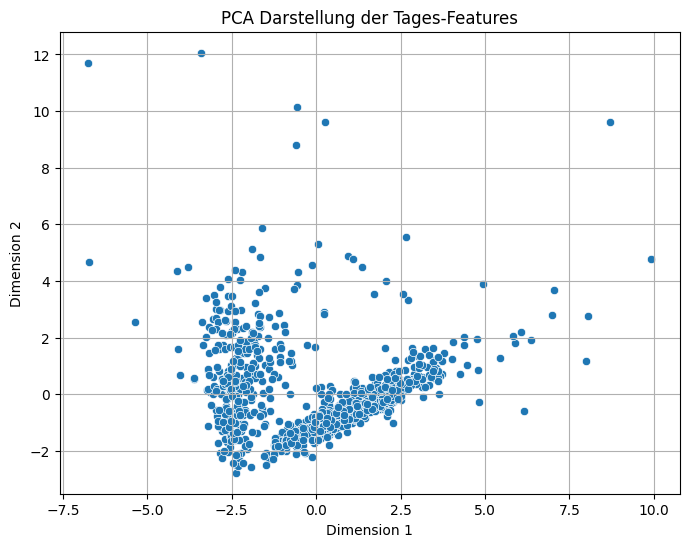

Erklärte Varianz für PCA Darstellung der Tages-Features:
 Komponente Erklärte Varianz
Dimension 1            33.6%
Dimension 2            20.9%

----------------------------------------



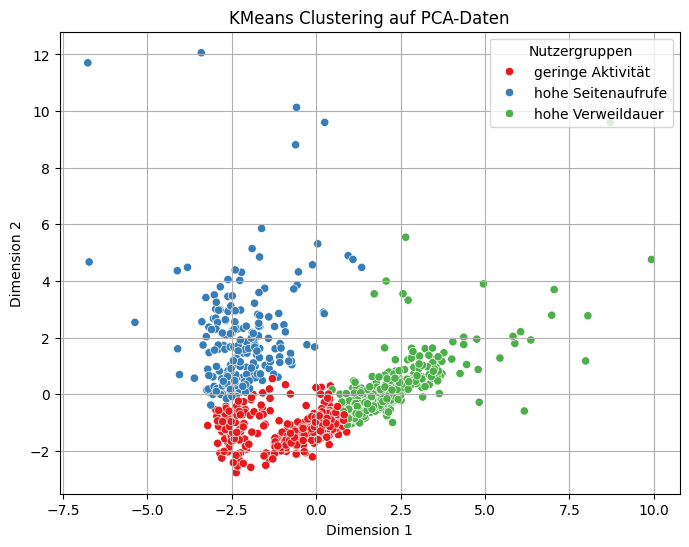

Erklärte Varianz für KMeans Clustering auf PCA-Daten:
 Komponente Erklärte Varianz
Dimension 1            33.6%
Dimension 2            20.9%

----------------------------------------



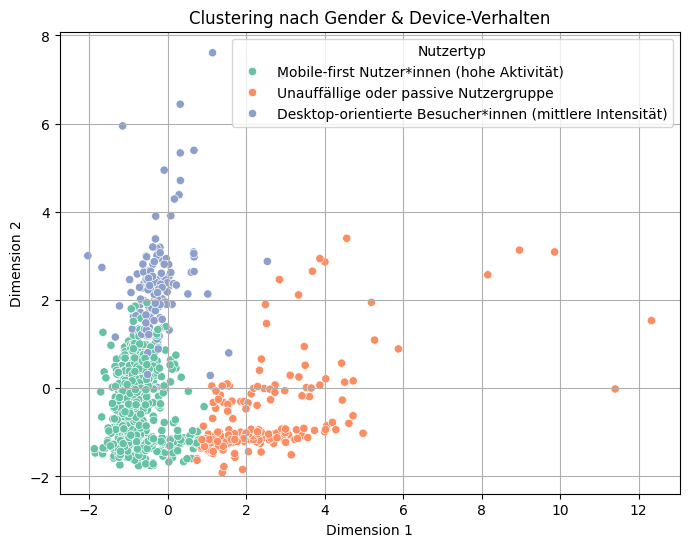

Erklärte Varianz für Clustering nach Gender & Device-Verhalten:
 Komponente Erklärte Varianz
Dimension 1            33.8%
Dimension 2            25.9%

----------------------------------------



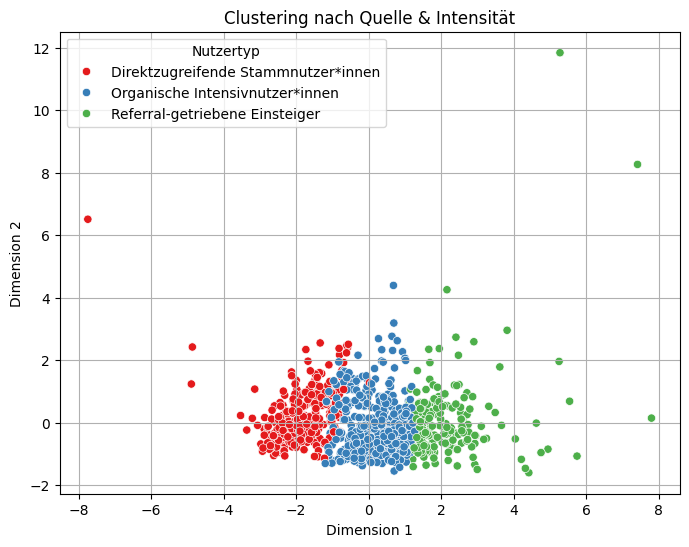

Erklärte Varianz für Clustering nach Quelle & Intensität:
 Komponente Erklärte Varianz
Dimension 1            46.0%
Dimension 2            16.8%

----------------------------------------



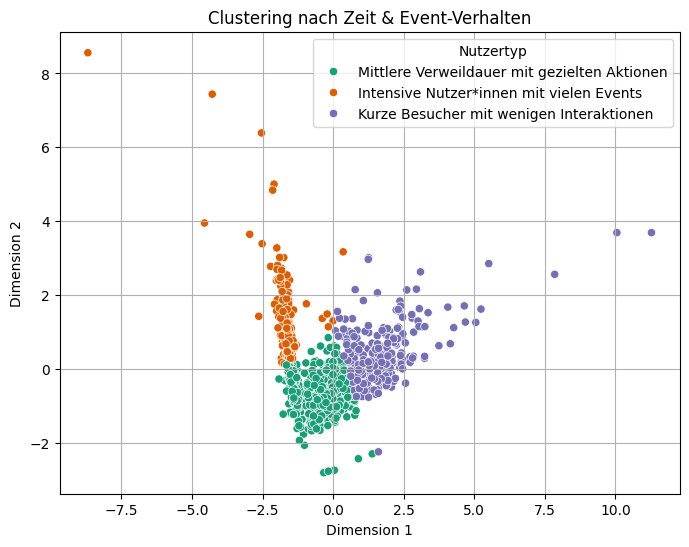

Erklärte Varianz für Clustering nach Zeit & Event-Verhalten:
 Komponente Erklärte Varianz
Dimension 1            54.8%
Dimension 2            29.5%

----------------------------------------



In [ ]:
# Clustering der Tagesdaten
def print_pca_variance(pca):
    # Kleine Tabelle mit erklärter Varianz
    var_df = pd.DataFrame(
        {
            "Komponente": ["Dimension 1", "Dimension 2"],
            "Erklärte Varianz": [f"{v:.1%}" for v in pca.explained_variance_ratio_],
        }
    )
    print(var_df.to_string(index=False))


def cluster_and_plot(
    data,
    features,
    n_clusters,
    cluster_labels,
    pca_cols,
    cluster_col,
    cluster_label_col,
    title,
    palette,
):
    X = data[features].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data[cluster_col] = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    data[pca_cols[0]] = pca_result[:, 0]
    data[pca_cols[1]] = pca_result[:, 1]

    data[cluster_label_col] = data[cluster_col].map(cluster_labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=pca_cols[0], y=pca_cols[1], hue=cluster_label_col, palette=palette, data=data
    )
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.legend(title="Nutzertyp")
    plt.show()

    # Varianz-Tabelle ausgeben
    print(f"Erklärte Varianz für {title}:")
    print_pca_variance(pca)
    print("\n" + "-" * 40 + "\n")


# 1. PCA und Scatterplot (ungeclustert) für Tages-Features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data["pca1"], data["pca2"] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", data=data)
plt.title("PCA Darstellung der Tages-Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

print("Erklärte Varianz für PCA Darstellung der Tages-Features:")
print_pca_variance(pca)
print("\n" + "-" * 40 + "\n")

# 2. KMeans Clustering auf skalierten Tages-Features + Plot
cluster_labels = {
    0: "geringe Aktivität",
    1: "hohe Verweildauer",
    2: "hohe Seitenaufrufe",
}
kmeans = KMeans(n_clusters=3, random_state=42)
data["cluster"] = kmeans.fit_predict(X_scaled)
data["cluster_label"] = data["cluster"].map(cluster_labels)

plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", hue="cluster_label", palette="Set1", data=data)
plt.title("KMeans Clustering auf PCA-Daten")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend(title="Nutzergruppen")
plt.show()

print("Erklärte Varianz für KMeans Clustering auf PCA-Daten:")
print_pca_variance(pca)
print("\n" + "-" * 40 + "\n")

# 3. Weitere Cluster-Analysen mit Funktion
cluster_and_plot(
    data=data,
    features=[
        "female",
        "male",
        "mobile",
        "desktop",
        "Seitenaufrufe",
        "Durchschn. Zeit auf der Seite",
        "Ereignisanzahl",
    ],
    n_clusters=3,
    cluster_labels={
        0: "Mobile-first Nutzer*innen (hohe Aktivität)",
        1: "Desktop-orientierte Besucher*innen (mittlere Intensität)",
        2: "Unauffällige oder passive Nutzergruppe",
    },
    pca_cols=["pca_gd1", "pca_gd2"],
    cluster_col="cluster_gd",
    cluster_label_col="cluster_label_gd",
    title="Clustering nach Gender & Device-Verhalten",
    palette="Set2",
)

cluster_and_plot(
    data=data,
    features=list(top3_sources.index)
    + ["Seiten / Sitzung", "Nutzer Insgesamt", "Ereignisanzahl"],
    n_clusters=3,
    cluster_labels={
        0: "Organische Intensivnutzer*innen",
        1: "Referral-getriebene Einsteiger",
        2: "Direktzugreifende Stammnutzer*innen",
    },
    pca_cols=["pca_src1", "pca_src2"],
    cluster_col="cluster_src",
    cluster_label_col="cluster_label_src",
    title="Clustering nach Quelle & Intensität",
    palette="Set1",
)

cluster_and_plot(
    data=data,
    features=[
        "Durchschn. Zeit auf der Seite",
        "Seiten / Sitzung",
        "Aktive Nutzer",
        "Ereignisanzahl",
    ],
    n_clusters=3,
    cluster_labels={
        0: "Kurze Besucher mit wenigen Interaktionen",
        1: "Intensive Nutzer*innen mit vielen Events",
        2: "Mittlere Verweildauer mit gezielten Aktionen",
    },
    pca_cols=["pca_te1", "pca_te2"],
    cluster_col="cluster_te",
    cluster_label_col="cluster_label_te",
    title="Clustering nach Zeit & Event-Verhalten",
    palette="Dark2",
)

## 🧠 Nutzerverhalten verstehen mit dem Apriori-Algorithmus

Der Apriori-Algorithmus hilft uns herauszufinden, welche **Nutzeraktionen auf der Website häufig gemeinsam auftreten** – quasi: „Wenn jemand X macht, macht er/sie meist auch Y.“  
Wir schauen uns das für **alle Nutzer*innen**, sowie getrennt nach **Device** (mobile vs. desktop) und **Gender** (female vs. male) an.

---

### 🧍‍♂️ Allgemein – Regeln für alle Nutzer

Die **häufigste Kombi** war:
- Wer **E-Mail, Checked und Website** nutzt, greift **mit hoher Wahrscheinlichkeit auch zum Telefon**.
- Umgekehrt: Wer **Phone** nutzt, hatte meistens auch **Email, Checked und Website** genutzt.

| Aktionen (Wenn...)                    | Dann auch... | Confidence | Lift |
|--------------------------------------|--------------|------------|------|
| Phone → Email + Checked + Website    | 91.7 %       | 1.09       |
| Email + Checked + Website → Phone    | 62.0 %       | 1.09       |

👉 Diese Kombinationen sind **leicht überdurchschnittlich stark verknüpft**, aber nicht spektakulär. Klassische „Kontakt-Aktivitätscluster“.

---

### 📱 Mobile Nutzer

Hier sind dieselben Aktionen **deutlich stärker miteinander verbunden**:

| Aktionen (Wenn...)                    | Dann auch... | Confidence | Lift |
|--------------------------------------|--------------|------------|------|
| Phone → Email + Checked + Website    | 90.4 %       | 1.99       |
| Website + Phone → Email + Checked    | 91.6 %       | 1.99       |

✅ **Lift fast 2** bedeutet: Diese Kombination kommt **fast doppelt so oft vor wie zufällig erwartet**. Das heißt: **Mobile Nutzer verhalten sich sehr konsistent**, wenn sie interagieren.

---

### 💻 Desktop Nutzer

Auch hier starke Verbindungen – sogar **noch stärker als bei Mobile!**

| Aktionen (Wenn...)                    | Dann auch... | Confidence | Lift |
|--------------------------------------|--------------|------------|------|
| Phone → Email + Checked + Website    | 86.4 %       | **2.20**   |
| Website + Phone → Email + Checked    | 87.5 %       | **2.20**   |

💡 Interpretation: Desktop-Nutzer **interagieren seltener, aber wenn sie es tun, dann richtig gebündelt**.

---

### 👩 Weibliche Nutzer

| Aktionen (Wenn...)                    | Dann auch... | Confidence | Lift |
|--------------------------------------|--------------|------------|------|
| Phone → Email + Checked + Website    | 92.2 %       | 1.53       |
| Website + Phone → Email + Checked    | 92.2 %       | 1.53       |

🧷 **Konsistentes Verhalten** – Ähnlich wie mobile Nutzer, aber weniger „krass“ als Desktop-User.

---

### 👨 Männliche Nutzer

Jetzt wird’s spannend:

| Aktionen (Wenn...)                     | Dann auch...       | Confidence | Lift   |
|---------------------------------------|---------------------|------------|--------|
| Checked + Phone → Email               | 97.1 %              | **5.54**   |
| Email + Website → Checked + Phone     | 56.4 %              | **5.59**   |
| Email → Checked + Website + Phone     | 55.9 %              | **5.54**   |

🔥 **Lift über 5!** → Das ist **extrem stark verknüpftes Verhalten**. Männer, die etwas tun, **machen fast alles auf einmal**. Diese Regeln sind besonders wertvoll für zielgerichtete UX-Verbesserung oder Kampagnen.

---

### 🧩 Fazit: Was sagen uns diese Regeln?

- **Kombinierte Interaktionen sind typisch**: Nutzer machen selten nur eine Sache – **Interaktionen bündeln sich** oft.
- **Desktop-Nutzer** und **männliche Besucher** zeigen **die stärkste Verknüpfung von Aktionen**.
- Erkenntnisse wie diese helfen, **Trigger für bestimmte Interaktionen zu finden** und gezielter Inhalte oder Call-to-Actions zu platzieren.

---



In [ ]:
# Apriori Algorithmus


def apriori_analysis(mode="all", min_supp=0.05):
    # 1. Pivot Events nach Datum
    event_pivot = df_what_did_user_do.pivot_table(
        index="datum",
        columns="name_des_events",
        values="aktive_nutzer",
        aggfunc="sum",
        fill_value=0,
    )

    if mode == "all":
        # Binarisieren
        event_binary = event_pivot.applymap(lambda x: 1 if x > 0 else 0)
        freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)
        if freq_items.empty:
            print("⚠️ Keine häufigen Event-Kombinationen für alle Nutzer gefunden.")
            return
        rules = association_rules(freq_items, metric="lift", min_threshold=1.0)
        label = "Alle Nutzer"

    elif mode == "device":
        # Pivot Devices
        devices_pivot = df_what_devices_used.pivot_table(
            index="datum",
            columns="kategorie",
            values="wert",
            aggfunc="sum",
            fill_value=0,
        )
        devices_share = devices_pivot.div(devices_pivot.sum(axis=1), axis=0).fillna(0)

        # Events gewichtet nach Device
        results = {}
        for device in ["mobile", "desktop"]:
            events_device = event_pivot.multiply(
                devices_share.get(device, 0), axis=0
            ).fillna(0)
            event_binary = events_device.round().applymap(lambda x: 1 if x > 0 else 0)
            freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)
            if freq_items.empty:
                print(
                    f"⚠️ Keine häufigen Event-Kombinationen für {device} Nutzer*innen gefunden."
                )
                continue
            rules = association_rules(freq_items, metric="lift", min_threshold=1.0)
            print(f"\nAssoziationsregeln für {device} Nutzer:")
            display(
                rules[["antecedents", "consequents", "support", "confidence", "lift"]]
                .sort_values(by="lift", ascending=False)
                .head(5)
            )
        return

    elif mode == "gender":
        # Pivot Gender
        gender_pivot = df_who_was_visiting.pivot_table(
            index="datum",
            columns="kategorie",
            values="wert",
            aggfunc="sum",
            fill_value=0,
        )
        gender_share = gender_pivot.div(gender_pivot.sum(axis=1), axis=0).fillna(0)

        # Events gewichtet nach Gender
        for gender in ["female", "male"]:
            events_gender = event_pivot.multiply(
                gender_share.get(gender, 0), axis=0
            ).fillna(0)
            event_binary = events_gender.round().applymap(lambda x: 1 if x > 0 else 0)
            freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)
            if freq_items.empty:
                print(
                    f"Keine häufigen Event-Kombinationen für {gender} Nutzer gefunden."
                )
                continue
            rules = association_rules(freq_items, metric="lift", min_threshold=1.0)
            print(f"\n Assoziationsregeln für {gender} Nutzer:")
            display(
                rules[["antecedents", "consequents", "support", "confidence", "lift"]]
                .sort_values(by="lift", ascending=False)
                .head(5)
            )
        return

    else:
        print("Modus nicht erkannt. Wähle 'all', 'device' oder 'gender'.")
        return

    # Ausgabe für Modus "all"
    print(f"\n Allgemeine Assoziationsregeln für {label}:")
    display(
        rules[["antecedents", "consequents", "support", "confidence", "lift"]]
        .sort_values(by="lift", ascending=False)
        .head(5)
    )


apriori_analysis("all")  # für alle Nutzer
apriori_analysis("device")  # für Mobile/Desktop
apriori_analysis("gender")  # für female/male


 Allgemeine Assoziationsregeln für Alle Nutzer:


,antecedents,consequents,support,confidence,lift
34,"(Email, Checked, Website)",(Phone),0.523585,0.620112,1.086477
47,(Phone),"(Email, Checked, Website)",0.523585,0.917355,1.086477
43,"(Website, Phone)","(Email, Checked)",0.523585,0.922438,1.084418
38,"(Email, Checked)","(Website, Phone)",0.523585,0.615527,1.084418
15,(Phone),"(Email, Checked)",0.525157,0.920110,1.081682



Assoziationsregeln für mobile Nutzer:


,antecedents,consequents,support,confidence,lift
49,(Phone),"(Email, Checked, Website)",0.247378,0.904153,1.989137
36,"(Email, Checked, Website)",(Phone),0.247378,0.544231,1.989137
45,"(Website, Phone)","(Email, Checked)",0.247378,0.915858,1.988124
40,"(Email, Checked)","(Website, Phone)",0.247378,0.537002,1.988124
12,"(Email, Checked)",(Phone),0.249126,0.540797,1.976587



Assoziationsregeln für desktop Nutzer:


,antecedents,consequents,support,confidence,lift
36,"(Email, Checked, Website)",(Phone),0.177448,0.451111,2.196047
49,(Phone),"(Email, Checked, Website)",0.177448,0.863830,2.196047
45,"(Website, Phone)","(Email, Checked)",0.177448,0.875000,2.195175
40,"(Email, Checked)","(Website, Phone)",0.177448,0.445175,2.195175
12,"(Email, Checked)",(Phone),0.177448,0.445175,2.167152



 Assoziationsregeln für female Nutzer:


,antecedents,consequents,support,confidence,lift
49,(Phone),"(Email, Checked, Website)",0.38724,0.922261,1.534825
36,"(Email, Checked, Website)",(Phone),0.38724,0.644444,1.534825
45,"(Website, Phone)","(Email, Checked)",0.38724,0.922261,1.527283
40,"(Email, Checked)","(Website, Phone)",0.38724,0.641278,1.527283
12,"(Email, Checked)",(Phone),0.38724,0.641278,1.527283



 Assoziationsregeln für male Nutzer:


,antecedents,consequents,support,confidence,lift
41,"(Email, Website)","(Checked, Phone)",0.097923,0.564103,5.591252
44,"(Checked, Phone)","(Email, Website)",0.097923,0.970588,5.591252
14,"(Checked, Phone)",(Email),0.097923,0.970588,5.543868
39,"(Checked, Website, Phone)",(Email),0.097923,0.970588,5.543868
46,(Email),"(Checked, Website, Phone)",0.097923,0.559322,5.543868


## 📈 Entwicklung der wichtigsten Besuchergruppen über Zeit

Um langfristige Trends besser zu verstehen, betrachten wir die Daten **quartalsweise** – also aufgeteilt in 3-Monats-Zeiträume. Dabei analysieren wir:

- Die **Top 3 Besucherquellen**
- Die **Geschlechterverteilung**
- Die **verwendeten Geräte**

---

### 🔝 Top 3 Besucherquellen pro Quartal

Wir zeigen hier die **drei wichtigsten Traffic-Quellen** über die Zeit – also woher die Besucher kamen:

- **Direkt**: Nutzer geben die URL direkt ein oder haben ein Lesezeichen.
- **Organisch**: Nutzer kommen über Suchmaschinen (z. B. Google).
- **Referral**: Besucher kommen über andere Websites oder Links.

Die Linien zeigen, **wie sich diese Quellen über die Quartale entwickeln** – also ob z. B. Referral-Traffic steigt oder ob Direktzugriffe konstant bleiben.

---

### 🚻 Geschlechterverteilung pro Quartal

Hier betrachten wir, **wie viele weibliche und männliche Nutzer pro Quartal** aktiv waren.  
Ziel: Erkenntnisse darüber, ob bestimmte Kampagnen oder Inhalte **eher bei einem Geschlecht ankommen** oder ob die **Verteilung stabil** bleibt.

Tipp: Ein plötzlicher Ausschlag bei einem Geschlecht kann auf gezielte Inhalte oder Kanäle hindeuten, die besonders wirksam waren.

---

### 📱 Geräteverwendung pro Quartal

Welche Geräte verwenden die Besucher am häufigsten?

- **Mobile**: Smartphones, Tablets etc.
- **Desktop**: Laptops und PCs

Dieser Trend ist besonders spannend für die **UX-Optimierung**:  
Steigt der Mobile-Traffic stark an, sollten Landingpages und Interaktionen besonders **für mobile Endgeräte** optimiert werden.

---

### 🧠 Warum ist das wichtig?

- Langfristige Trends helfen, **strategische Entscheidungen zu treffen**.
- Verschiebungen im Verhalten (z. B. mehr Mobile, mehr weibliche Nutzer*innen) deuten oft auf **Veränderungen im Zugang, in der Zielgruppe oder in der Wirkung von Maßnahmen** hin.
- Quartalsdaten sind robust genug, um saisonale Effekte zu erkennen, ohne sich im Tagesrauschen zu verlieren.

---



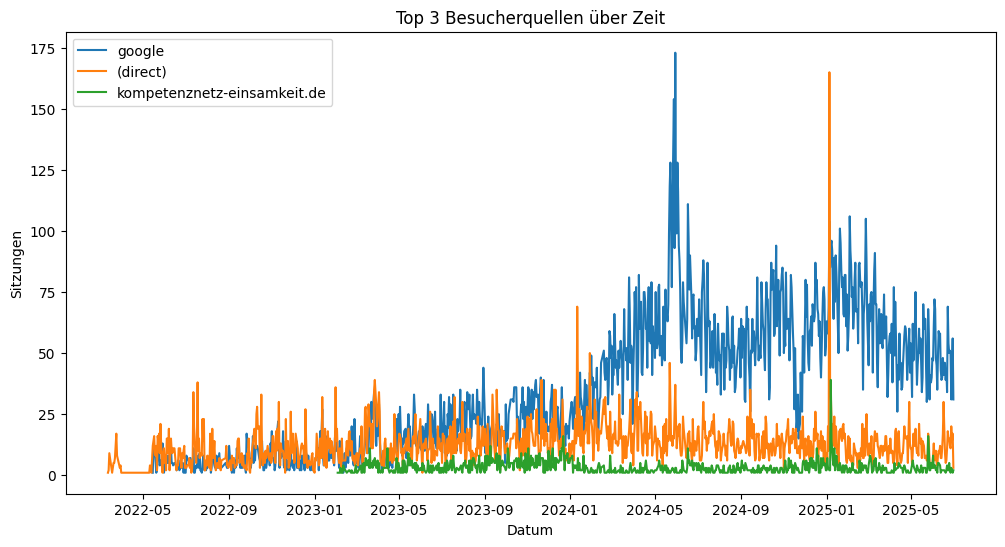

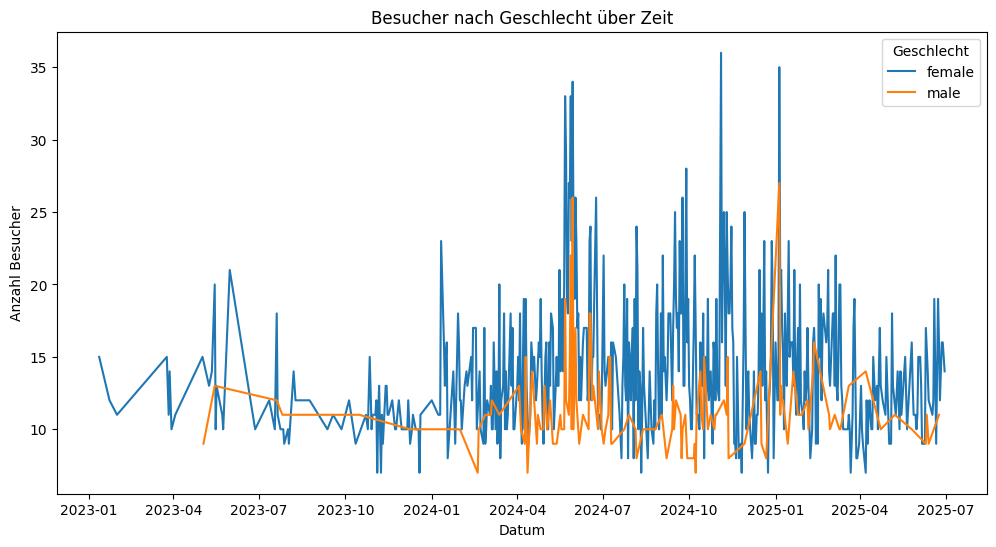

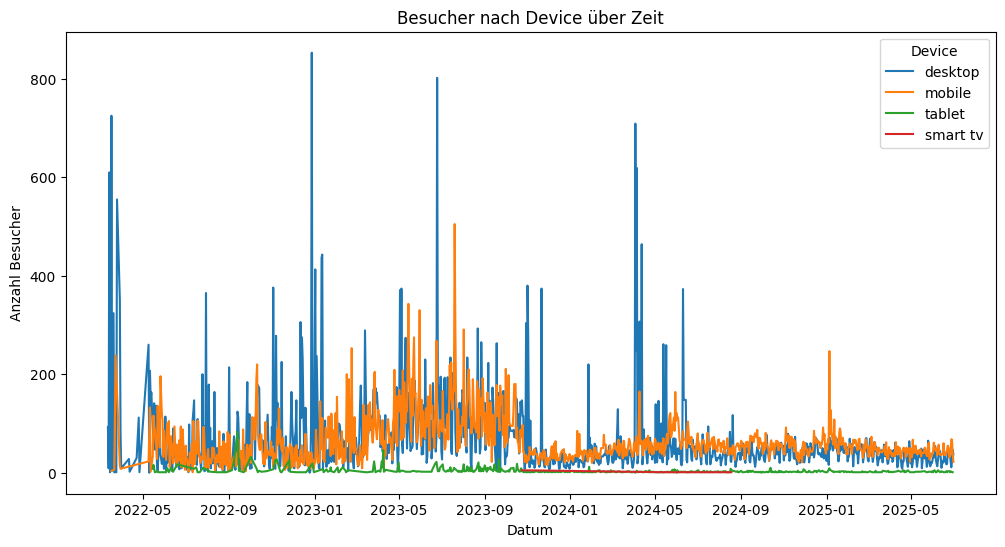

In [ ]:
# Top 3 Besucherquellen über Zeit
top_sources = (
    df_where_did_they_come_from.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

plt.figure(figsize=(12, 6))
for source in top_sources:
    subset = df_where_did_they_come_from[
        df_where_did_they_come_from["quelle"] == source
    ]
    subset_agg = subset.groupby("datum")["sitzungen"].sum().reset_index()
    sns.lineplot(data=subset_agg, x="datum", y="sitzungen", label=source)

plt.title("Top 3 Besucherquellen über Zeit")
plt.xlabel("Datum")
plt.ylabel("Sitzungen")
plt.legend()
plt.show()

# Geschlechter über Zeit plotten
df_gender = (
    df_who_was_visiting.groupby(["datum", "kategorie"])["wert"].sum().reset_index()
)

# Plot mit seaborn, x=datum, y=anzahl, hue=gender (für verschiedene Linien)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_gender, x="datum", y="wert", hue="kategorie")

plt.title("Besucher nach Geschlecht über Zeit")
plt.xlabel("Datum")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Geschlecht")
plt.show()


# Devices über Zeit plotten
df_devices = (
    df_what_devices_used.groupby(["datum", "kategorie"])["wert"].sum().reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_devices, x="datum", y="wert", hue="kategorie")

plt.title("Besucher nach Device über Zeit")
plt.xlabel("Datum")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Device")
plt.show()

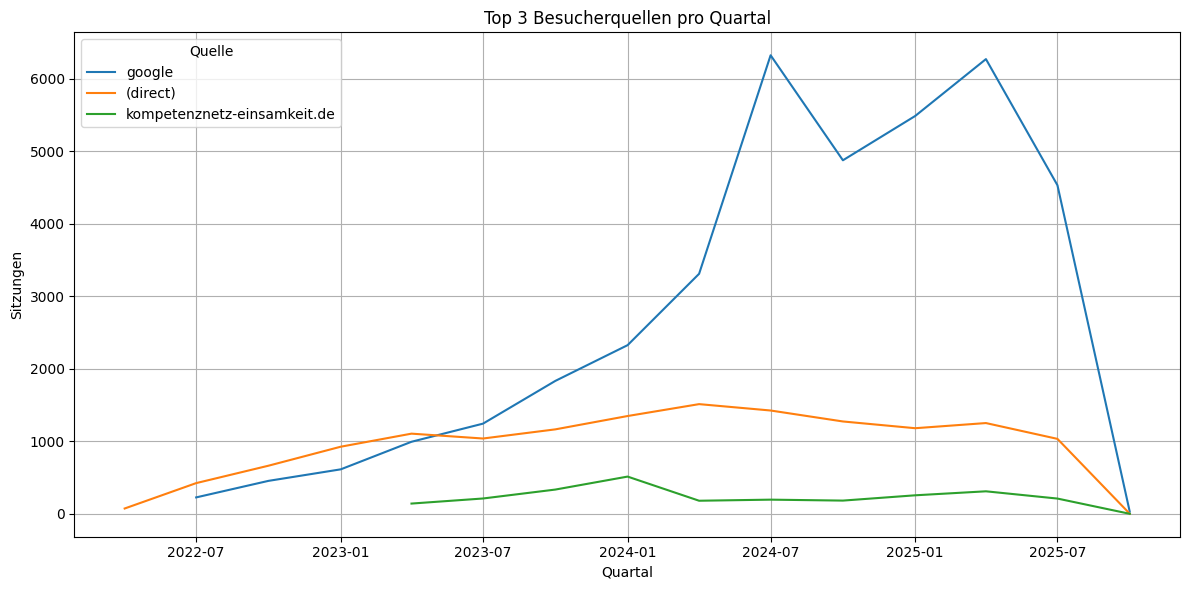

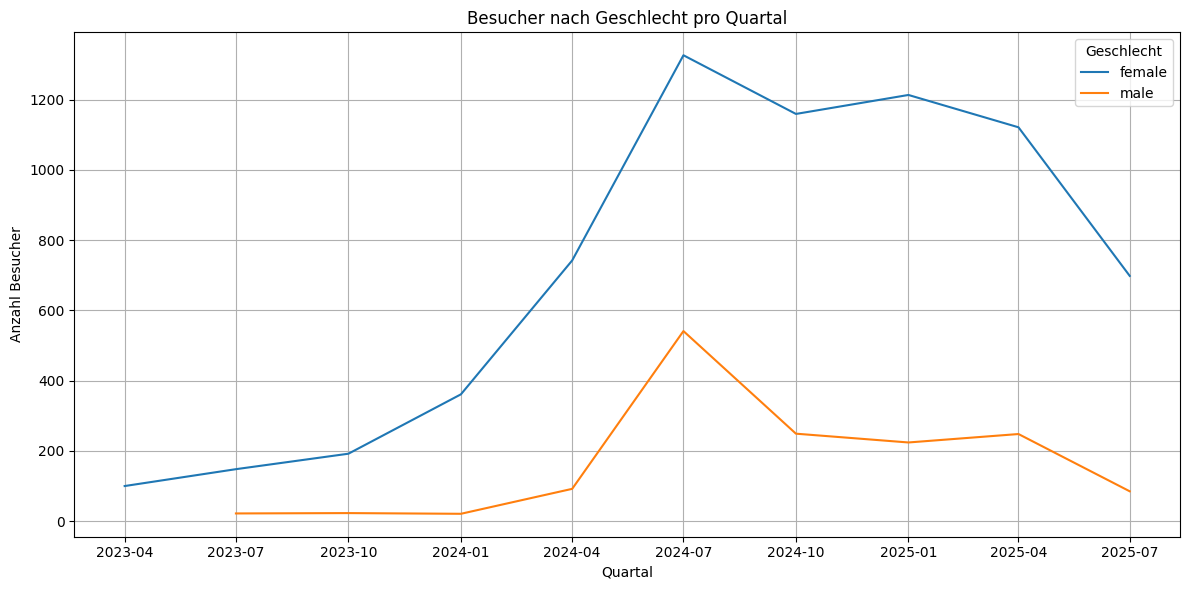

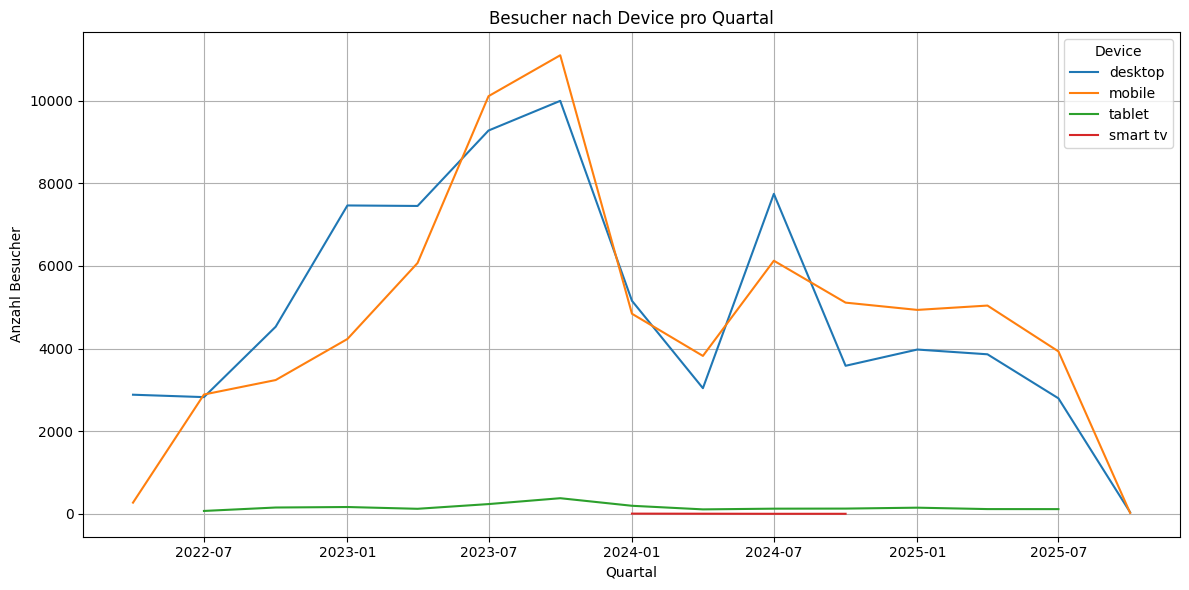

In [ ]:
# --- Top 3 Besucherquellen pro Quartal ---
df_sources = df_where_did_they_come_from.copy()
df_sources["datum"] = pd.to_datetime(df_sources["datum"])
df_sources["quartal"] = df_sources["datum"].dt.to_period("Q")

top_sources = (
    df_sources.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

plt.figure(figsize=(12, 6))
for source in top_sources:
    subset = df_sources[df_sources["quelle"] == source]
    subset_agg = subset.groupby("quartal")["sitzungen"].sum().reset_index()
    subset_agg["quartal"] = subset_agg["quartal"].dt.to_timestamp(how="e")
    sns.lineplot(data=subset_agg, x="quartal", y="sitzungen", label=source)

plt.title("Top 3 Besucherquellen pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Sitzungen")
plt.legend(title="Quelle")
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Geschlechter pro Quartal ---
df_gender = df_who_was_visiting.copy()
df_gender["datum"] = pd.to_datetime(df_gender["datum"])
df_gender["quartal"] = df_gender["datum"].dt.to_period("Q")

df_quartal_gender = (
    df_gender.groupby(["quartal", "kategorie"])["wert"].sum().reset_index()
)
df_quartal_gender["quartal"] = df_quartal_gender["quartal"].dt.to_timestamp(how="e")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_quartal_gender, x="quartal", y="wert", hue="kategorie")

plt.title("Besucher nach Geschlecht pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Geschlecht")
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Devices pro Quartal ---
df_devices = df_what_devices_used.copy()
df_devices["datum"] = pd.to_datetime(df_devices["datum"])
df_devices["quartal"] = df_devices["datum"].dt.to_period("Q")

df_quartal_devices = (
    df_devices.groupby(["quartal", "kategorie"])["wert"].sum().reset_index()
)
df_quartal_devices["quartal"] = df_quartal_devices["quartal"].dt.to_timestamp(how="e")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_quartal_devices, x="quartal", y="wert", hue="kategorie")

plt.title("Besucher nach Device pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Device")
plt.grid(True)
plt.tight_layout()
plt.show()

<h2>📊 Cluster-Analyse der Landingpages: Nutzungsintensität verstehen</h2>

<p>Um die Nutzung der Landingpages besser zu verstehen, haben wir die Seiten nach ihrer <strong>Aufrufhäufigkeit</strong> in drei Cluster eingeteilt:</p>

<ul>
  <li><strong>Wenig aufgerufen</strong></li>
  <li><strong>Durchschnittlich aufgerufen</strong></li>
  <li><strong>Häufig aufgerufen</strong></li>
</ul>

<p>Diese Labels basieren auf den <strong>Mittelwerten der Aufrufe je Cluster</strong> – so können wir die Gruppen klar und verständlich benennen.</p>

<hr>

<h3>🏷️ Wie wurden die Labels vergeben?</h3>

<p>Wir haben zunächst den <strong>durchschnittlichen Aufrufwert pro Cluster</strong> berechnet und die Cluster dann nach diesem Wert sortiert.<br>
So entsteht eine nachvollziehbare Reihenfolge vom „schwächsten“ bis zum „stärksten“ Cluster.</p>

<hr>

<h3>🔝 Top 15 Landingpages und ihre Nutzung</h3>

<p>Anschließend haben wir uns die <strong>Top 15 am häufigsten aufgerufenen Landingpages</strong> angesehen und sie mit den Cluster-Labels versehen.</p>

<p>Die Verteilung zeigt:<br>
- 8 Seiten sind „durchschnittlich aufgerufen“<br>
- 5 Seiten „wenig aufgerufen“<br>
- 2 Seiten „häufig aufgerufen“</p>

<hr>

<h3>📊 Warum ist das nützlich?</h3>

<ul>
  <li>Die Cluster-Labels machen es leichter, <strong>Landingpages nach Nutzungsintensität zu gruppieren und zu analysieren</strong>.</li>
  <li>So lassen sich z. B. Seiten mit Potenzial für mehr Traffic identifizieren oder solche, die vielleicht überarbeitet werden sollten.</li>
  <li>Der farbige Balken-Plot gibt auf einen Blick Aufschluss über die Verteilung und die Unterschiede der wichtigsten Seiten.</li>
</ul>


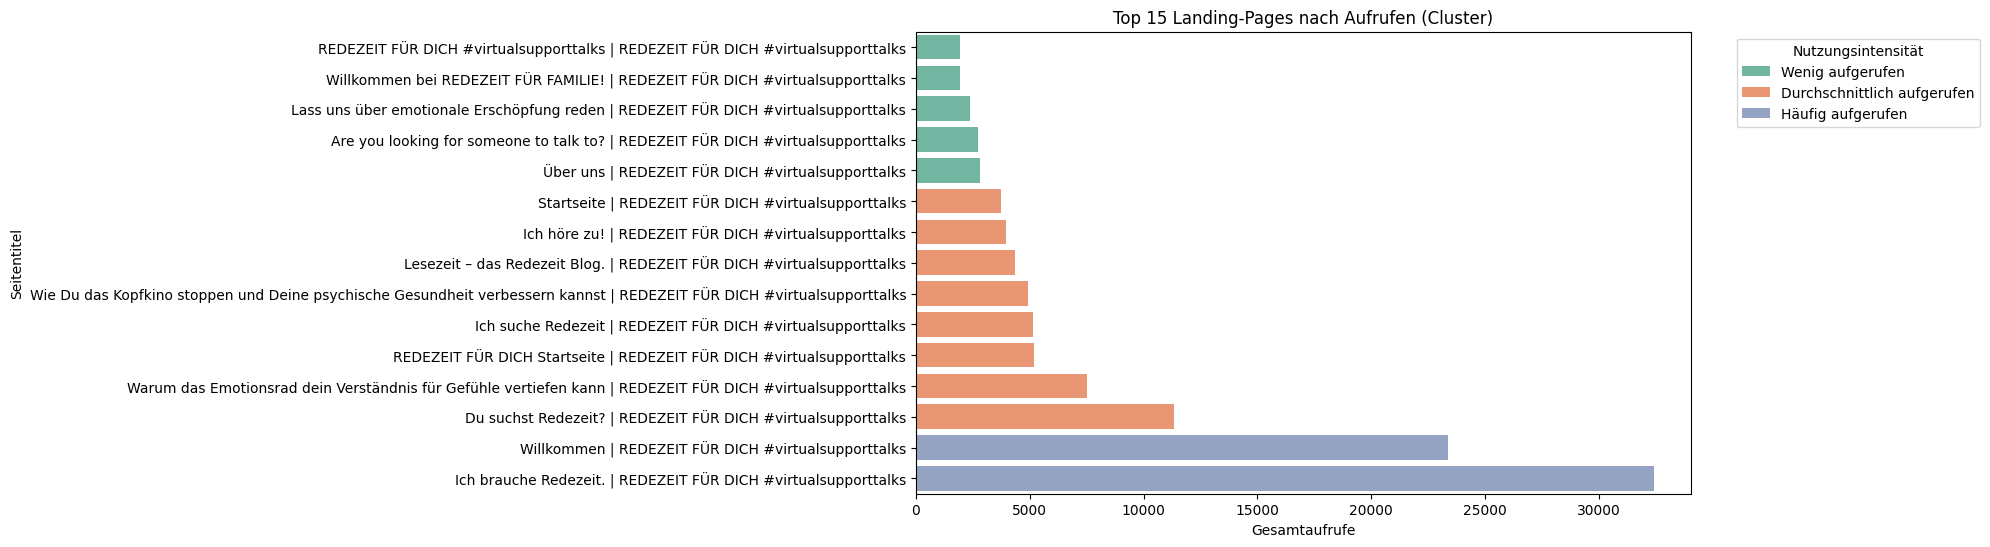

In [ ]:
# Mittelwerte je Cluster berechnen (für sinnvolle Labels)
cluster_means = df_lp.groupby("cluster")["aufrufe"].mean().sort_values()

# Mapping von Cluster‐Index zu verständlichem Label
cluster_labels = {
    cluster_means.index[0]: "Wenig aufgerufen",
    cluster_means.index[1]: "Durchschnittlich aufgerufen",
    cluster_means.index[2]: "Häufig aufgerufen",
}

# Labels in DataFrame übernehmen
df_lp["cluster_label"] = df_lp["cluster"].map(cluster_labels)

# Nur die Top 15 Landingpages
top_lp = df_lp.sort_values("aufrufe", ascending=False).head(15)

# Plot mit beschrifteter Legende
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_lp.sort_values("aufrufe"),
    y="seitentitel",
    x="aufrufe",
    hue="cluster_label",
    palette="Set2",
)
plt.title("Top 15 Landing‑Pages nach Aufrufen (Cluster)")
plt.xlabel("Gesamtaufrufe")
plt.ylabel("Seitentitel")
plt.legend(title="Nutzungsintensität", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<h2>📊 Analyse der Besucherquellen mit Clustering</h2>

<p>Wir haben die wichtigsten Kennzahlen für verschiedene Besucherquellen zusammengefasst:</p>
<ul>
  <li><strong>Sitzungen:</strong> Anzahl der Besuche</li>
  <li><strong>Aufrufe:</strong> Seitenaufrufe insgesamt</li>
  <li><strong>Aufrufe pro Sitzung:</strong> Durchschnittliche Seitenaufrufe je Besuch</li>
</ul>

<h3>🔎 Schritt 1 &amp; 2: Quellen gruppieren</h3>
<p>Die Top 4 Quellen werden einzeln betrachtet, alle anderen bündeln wir in "Andere". So behalten wir den Überblick, ohne dass seltene Quellen die Analyse verzerren.</p>

<h3>🔍 Schritt 3: Clustering</h3>
<p>Wir haben die Quellen basierend auf Sitzungen, Aufrufen und Aufrufen pro Sitzung in 3 Cluster eingeteilt, um typische Besucherquellen-Gruppen zu erkennen:</p>
<ul>
  <li><strong>Cluster 0:</strong> Kleiner Traffic, moderates Engagement</li>
  <li><strong>Cluster 1:</strong> Großer Traffic, geringes Engagement</li>
  <li><strong>Cluster 2:</strong> Mittlerer Traffic, hohes Engagement</li>
</ul>

<h3>📈 Interpretation der Cluster</h3>
<ul>
  <li><strong>Großer Traffic, geringes Engagement (Cluster 1):</strong> Quellen mit vielen Sitzungen, aber eher wenigen Seitenaufrufen pro Besuch (z.B. "google").</li>
  <li><strong>Mittlerer Traffic, hohes Engagement (Cluster 2):</strong> Quellen mit weniger Besuchen als Cluster 1, aber viel mehr Seitenaufrufen pro Sitzung (z.B. "direct").</li>
  <li><strong>Kleiner Traffic, moderates Engagement (Cluster 0):</strong> Quellen mit wenig Traffic und moderaten Seitenaufrufen pro Sitzung (z.B. "Andere", "kompetenznetz-einsamkeit.de").</li>
</ul>

<h3>💡 Fazit</h3>
<p>Diese Clustering-Analyse hilft, die Besucherquellen besser zu verstehen und gezielt Prioritäten zu setzen:</p>
<ul>
  <li><em>Große Traffic-Quellen</em> wie "google" brauchen Maßnahmen, um das Engagement zu erhöhen.</li>
  <li><em>Direktzugriffe</em> sind sehr engagiert, hier lohnt sich eine Pflege der Inhalte.</li>
  <li><em>Andere Quellen</em> sollten weiter beobachtet werden, da sie zwar kleiner sind, aber dennoch wertvolles Engagement liefern können.</li>
</ul>


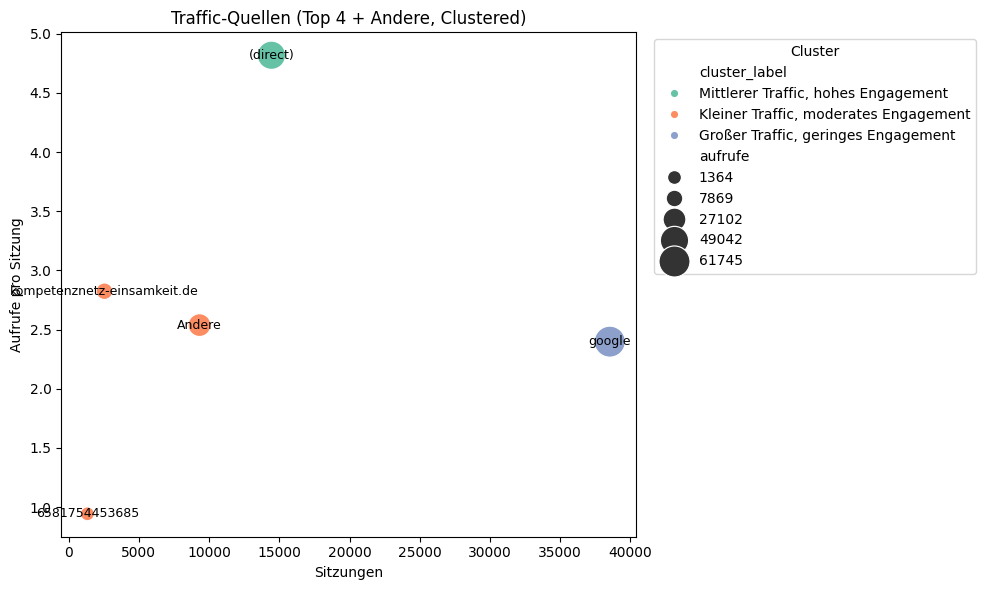

In [ ]:
# Metriken berechnen
df_ts = (
    df_where_did_they_come_from.groupby("quelle")
    .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
    .reset_index()
)

# Schritt 2: Nur Top 4 Quellen einzeln zeigen – Rest zu "Andere" zusammenfassen
top_n = 4
top_quellen = df_ts.sort_values("sitzungen", ascending=False).head(top_n)["quelle"]
df_ts["quelle_gruppe"] = df_ts["quelle"].where(
    df_ts["quelle"].isin(top_quellen), "Andere"
)

# Aggregation nach Quelle-Gruppe
df_ts_agg = (
    df_ts.groupby("quelle_gruppe")
    .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
    .reset_index()
)

# Schritt 3: Clustering
scaler = StandardScaler()
X = scaler.fit_transform(df_ts_agg[["sitzungen", "aufrufe", "aufrufe_pro_sitzung"]])
kmeans = KMeans(n_clusters=3, random_state=42)
df_ts_agg["cluster"] = kmeans.fit_predict(X)


# Schritt 4: Cluster-Labels definieren (basierend auf deiner Interpretation)
def cluster_label(cluster):
    if cluster == 0:
        return "Kleiner Traffic, moderates Engagement"
    elif cluster == 1:
        return "Großer Traffic, geringes Engagement"
    else:
        return "Mittlerer Traffic, hohes Engagement"


df_ts_agg["cluster_label"] = df_ts_agg["cluster"].apply(cluster_label)

# cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
# cluster_summary = pd.DataFrame(cluster_centers, columns=['sitzungen', 'aufrufe', 'aufrufe_pro_sitzung'])
# display("Cluster Zentren")
# display(cluster_summary)

# Schritt 5: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_ts_agg,
    x="sitzungen",
    y="aufrufe_pro_sitzung",
    size="aufrufe",
    hue="cluster_label",
    sizes=(100, 500),
    palette="Set2",
    legend="full",
)
for _, row in df_ts_agg.iterrows():
    plt.text(
        row["sitzungen"],
        row["aufrufe_pro_sitzung"],
        row["quelle_gruppe"],
        fontsize=9,
        ha="center",
        va="center",
    )

plt.title("Traffic‑Quellen (Top 4 + Andere, Clustered)")
plt.xlabel("Sitzungen")
plt.ylabel("Aufrufe pro Sitzung")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 📊 Clusteranalyse der Geräte-Nutzung über die Zeit

### Was passiert im Code?

Wir wollen verstehen, wie sich die Nutzung verschiedener Geräte (Desktop, Mobile, Smart TV, Tablet) über die Zeit verhält – und ob es dabei verschiedene Nutzertypen gibt.

1. Die Zeitreihen-Daten (Gerätenutzung pro Tag) werden gruppiert und für jedes Gerät aufgearbeitet.  
2. Mit **KShape-Clustering** werden ähnliche Nutzungsverläufe automatisch in Gruppen (Cluster) zusammengefasst – das hilft, Muster zu erkennen, z. B. ob manche Geräte konstant genutzt werden oder ob die Nutzung stark schwankt.  
3. Für jedes Cluster sehen wir die durchschnittlichen Nutzungs-Trends (Clusterzentren), also das typische Nutzungsverhalten in dieser Gruppe.  
4. Die Cluster werden durchnummeriert (z. B. Cluster 0, Cluster 1) – wir interpretieren später, was die einzelnen Gruppen bedeuten könnten.  
5. Schließlich visualisieren wir die Zeitreihen und die Clusterzentren, damit wir die Ergebnisse gut vergleichen können.

---

### Ergebnisse im Überblick

#### Cluster Labels  
Das KShape-Clustering hat 2 Gruppen gefunden, die die Geräte-Nutzungsmuster gut zusammenfassen. Die Geräte wurden so gruppiert:  

- Cluster 0: Geräte mit relativ stabiler oder geringer Nutzung über die Zeit  
- Cluster 1: Geräte mit stärker schwankender oder höherer Nutzung  

#### Clusterzentren  
Die Clusterzentren zeigen den typischen Verlauf der Nutzung über die Tage. Sie sind „durchschnittliche“ Kurven, die für jedes Cluster stehen:  

- Cluster 0 hat eine flachere, konstantere Kurve  
- Cluster 1 zeigt einen deutlicheren Anstieg oder mehr Schwankungen  

#### Zeitliche Daten & Geräte-Kategorien  
- Die Zeitpunkte sind die Tage, an denen die Nutzung gemessen wurde (z. B. vom 12. März 2022 bis zum 21. März 2022).  
- Die Geräte-Kategorien sind Desktop, Mobile, Smart TV und Tablet.  

---

### Warum ist das wichtig?

- So können wir erkennen, ob bestimmte Gerätegruppen ähnlich genutzt werden – z. B. ob Mobile und Tablet ähnlich verlaufen oder sich komplett unterscheiden.  
- Erkenntnisse aus dem Clustering helfen, gezielter Inhalte oder technische Anpassungen für bestimmte Gerätegruppen zu planen.  
- Die zeitliche Dimension erlaubt es, Trends oder saisonale Effekte in der Nutzung zu erkennen.

---

Geräte‑Nutzung - Clusteranzahl: 2


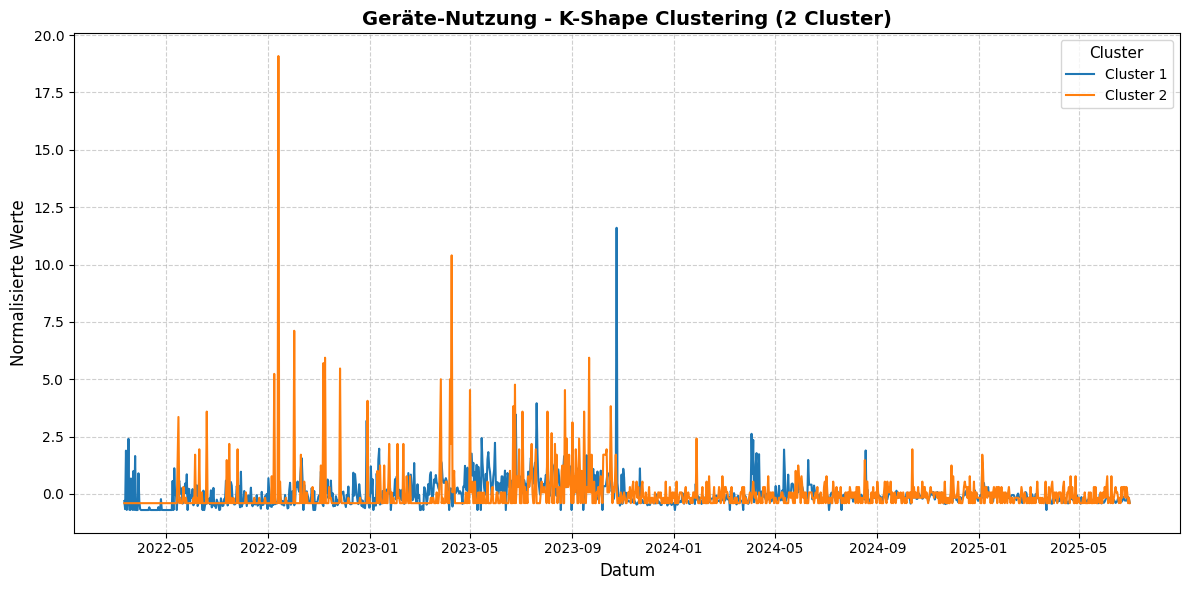

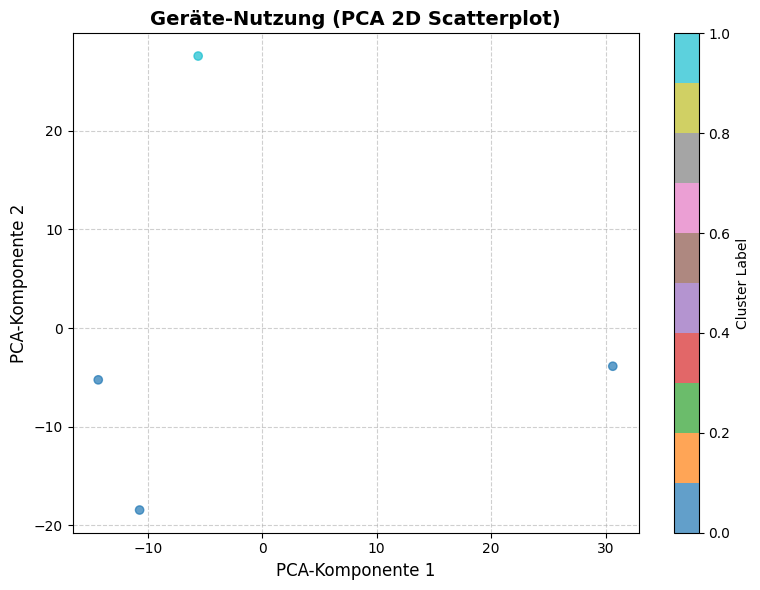

In [ ]:
# Clusteranalyse
labels_dev, model_dev, dates_dev, cats_dev = cluster_timeseries_table(
    df_what_devices_used,
    date_col="datum",
    category_col="kategorie",
    value_col="wert",
    fill_value=0,
    title_prefix="Geräte‑Nutzung",
)

<h1>Erkennung und Visualisierung von ungewöhnlichen Tagen bei Seitenaufrufen</h1>

<p>Dieser Code zeigt uns, an welchen Tagen die Seitenaufrufe auf der Website besonders ungewöhnlich waren – also Ausreißer-Tage, die sich stark von normalen Tagen unterscheiden.</p>

<h2>Was macht der Code genau?</h2>

<ol>
  <li><strong>Datenpunkte darstellen:</strong> Jeder Punkt im Diagramm steht für die Seitenaufrufe an einem bestimmten Tag.</li>
  <li><strong>Farbliche Unterscheidung:</strong> Normale Tage sind blau dargestellt, ungewöhnliche (Ausreißer) Tage schwarz.</li>
  <li><strong>Datum hervorheben:</strong> Über jedem schwarzen Ausreißer-Punkt steht das genaue Datum in weißer Schrift auf schwarzem Hintergrund. So erkennt man sofort, an welchem Tag dieser Ausreißer aufgetreten ist.</li>
  <li><strong>Leichte Versetzung:</strong> Das Datum wird etwas oberhalb des Punktes angezeigt, damit es nicht überlappt und gut lesbar bleibt.</li>
</ol>

<h2>Was sieht man im Ergebnis?</h2>

<ul>
  <li>Viele blaue Punkte: Das sind ganz normale Tage mit üblichen Seitenaufrufen.</li>
  <li>Einige schwarze Punkte: Das sind die Ausreißer-Tage mit ungewöhnlich hohen oder niedrigen Seitenaufrufen.</li>
  <li>Zu jedem schwarzen Punkt sieht man das genaue Datum, so dass man schnell erkennt, wann die ungewöhnlichen Ereignisse stattgefunden haben.</li>
</ul>

<p>Diese Darstellung hilft dabei, besondere Tage mit auffälligen Besucherzahlen leicht zu erkennen und genau zuzuordnen.</p>


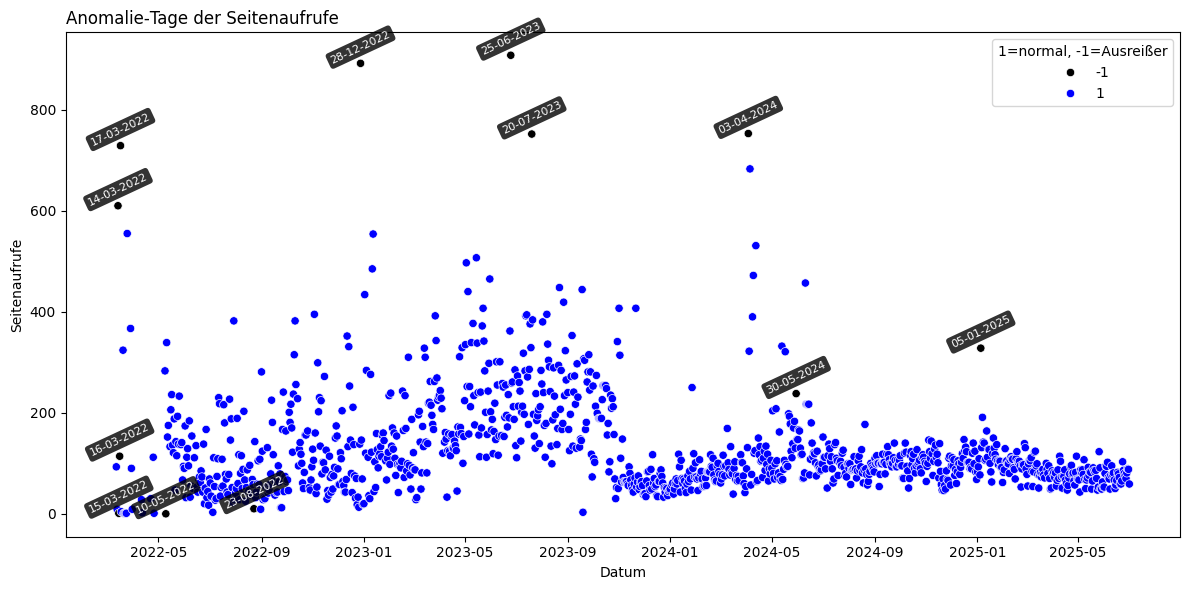

'Ausreißer-Tage:'

,datum,seitenaufrufe,nutzer_insgesamt,absprungrate_in_prozent
2,2022-03-14,610,3,0.00
3,2022-03-15,1,2,100.00
4,2022-03-16,114,2,100.00
5,2022-03-17,729,2,100.00
22,2022-05-10,0,1,100.00
123,2022-08-23,10,6,100.00
247,2022-12-28,892,12,10.53
419,2023-06-25,908,29,3.13
444,2023-07-20,752,131,4.76
695,2024-04-03,753,88,31.13


In [ ]:
# Alle Ausreißer-Tage herausfiltern

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=daily,
    x="datum",
    y="seitenaufrufe",
    hue="anomaly",
    palette={1: "blue", -1: "black"},
)

# Ausreißer mit schwarzem Hintergrund und weißem Text beschriften
for _, row in anomaly_days.iterrows():
    plt.text(
        row["datum"],
        row["seitenaufrufe"],
        row["datum"].strftime("%d-%m-%Y"),
        color="white",
        fontsize=8,
        rotation=25,
        ha="center",
        bbox=dict(
            facecolor="black", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"
        ),
    )

plt.title("Anomalie‑Tage der Seitenaufrufe", loc="left")
plt.xlabel("Datum")
plt.ylabel("Seitenaufrufe")
plt.legend(title="1=normal, -1=Ausreißer")
plt.tight_layout()
plt.show()

# Alle Ausreißer-Tage herausfiltern
anomaly_days = daily[daily["anomaly"] == -1][
    ["datum", "seitenaufrufe", "nutzer_insgesamt", "absprungrate_in_prozent"]
]

display("Ausreißer-Tage:")
display(anomaly_days)

<h1>Analyse der Zeitreihe: Trend, saisonale Muster und Rest bei Seitenaufrufen</h1>

<p>Mit diesem Code wird die Entwicklung der täglichen Seitenaufrufe über etwa ein Jahr untersucht. Dabei wird die Zeitreihe in mehrere Bestandteile zerlegt, um Muster besser zu verstehen:</p>

<h2>Was macht der Code genau?</h2>
<ul>
  <li><strong>Datenvorbereitung:</strong> Die täglichen Seitenaufrufe werden als Zeitreihe geordnet (Index ist das Datum). Fehlende Tage werden ergänzt, und fehlende Werte werden mit dem letzten bekannten Wert aufgefüllt.</li>
  <li><strong>Zerlegung (seasonal_decompose):</strong> Die Methode teilt die Daten in drei Teile auf:</li>
  <ul>
    <li><strong>Trend:</strong> Der langfristige Verlauf. Zeigt, ob die Seitenaufrufe im Mittel steigen, fallen oder stabil bleiben.</li>
    <li><strong>Saisonale Komponente:</strong> Wiederkehrende Schwankungen innerhalb eines Jahres (hier 365 Tage). Zum Beispiel höhere Aufrufe zu bestimmten Jahreszeiten oder Wochentagen.</li>
    <li><strong>Residual (Rest):</strong> Der Teil, der nicht durch Trend oder saisonale Muster erklärt wird – also zufällige Schwankungen oder Ausreißer.</li>
  </ul>
  <li><strong>Visualisierung:</strong> Die Grafik zeigt alle drei Teile als separate Linienplots, damit man sie gut vergleichen kann.</li>
</ul>

<h2>Was sieht man in der Grafik?</h2>
<ul>
  <li><strong>Originaldaten (obere Grafik):</strong> Die echten täglichen Seitenaufrufe.</li>
  <li><strong>Trend (zweite Grafik):</strong> Die geglättete Linie, die den allgemeinen Aufwärts- oder Abwärtstrend zeigt. Anfangs fehlen hier Werte, weil der Algorithmus erst genug Daten braucht, um den Trend zu berechnen.</li>
  <li><strong>Saisonale Komponente (dritte Grafik):</strong> Die regelmäßigen Schwankungen, die sich im Laufe eines Jahres wiederholen. Positive Werte zeigen Tage mit mehr Besuchern als der Trend erwartet, negative Werte Tage mit weniger Besuchern.</li>
  <li><strong>Residual / Rest (unterste Grafik):</strong> Die "Reste", also alles, was nicht durch Trend oder saisonale Muster erklärt wird. Hier sind die zufälligen Schwankungen und Ausreißer sichtbar.</li>
</ul>

<h2>Warum ist das wichtig?</h2>
<ul>
  <li><strong>Trend erkennen:</strong> Man sieht, ob die Webseite insgesamt mehr oder weniger besucht wird – eine wichtige Grundlage für Entscheidungen über Wachstum und Entwicklung.</li>
  <li><strong>Saisonale Muster verstehen:</strong> Man erkennt typische wiederkehrende Zeiten mit hoher oder niedriger Besucherzahl – etwa Feiertage, Wochenenden oder saisonale Einflüsse.</li>
  <li><strong>Rest analysieren:</strong> Hilft dabei, unerwartete Ereignisse (z.B. plötzliche Traffic-Spitzen) von normalen Mustern zu unterscheiden.</li>
  <li>Das alles hilft, die Webseite besser zu steuern, z.B. für Marketingaktionen, Serverplanung oder Nutzeranalysen.</li>
</ul>

<p>Zusammengefasst: Diese Zerlegung zeigt dir, wie sich deine Besucherzahlen über das Jahr verteilt entwickeln, welche regelmäßigen Muster es gibt und welche Schwankungen außergewöhnlich sind.</p>


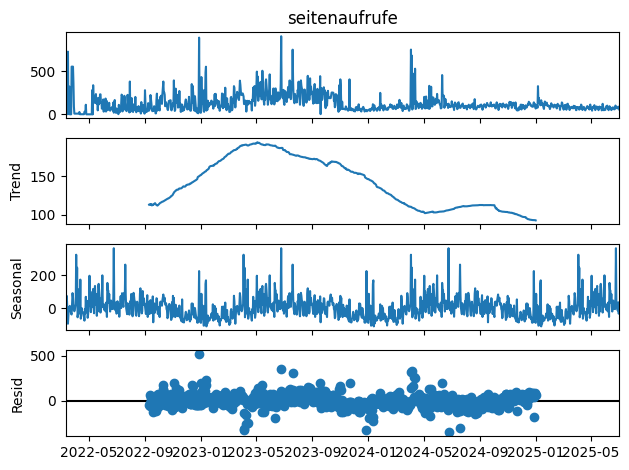

In [ ]:
# Analyse der Zeitreihe
ts = (
    df_user_behaviors.set_index("datum")["seitenaufrufe"]
    .asfreq("D")
    .fillna(method="ffill")
)
res = seasonal_decompose(ts, model="additive", period=365)
res.plot()
plt.tight_layout()
plt.show()
# display(res.trend.head())
# display(res.seasonal.head())

 <h2>Was zeigt dieser Plot? (PCA & K-Means für Nutzerverhalten)</h2>

  <p>
    In diesem Abschnitt wurde analysiert, wie sich Nutzer:innen auf der Website verhalten – also zum Beispiel:
  </p>

  <ul>
    <li>Wie viele Seiten sie aufrufen</li>
    <li>Wie lange sie bleiben</li>
    <li>Wie oft sie abspringen</li>
    <li>Wie viele Seiten sie pro Sitzung anschauen</li>
  </ul>

  <h3>Was macht der Code eigentlich?</h3>

  <ol>
    <li><strong>Alle Nutzungsdaten werden zusammengeführt</strong> – z. B. Seitenaufrufe, Aufenthaltsdauer, Absprungrate usw.</li>
    <li><strong>Die Werte werden standardisiert</strong>, damit alle Merkmale vergleichbar sind (z. B. Prozentwerte und Sekunden).</li>
    <li>
      <strong>Dann kommt PCA (Hauptkomponentenanalyse):</strong>
      <ul>
        <li>Reduziert viele Merkmale auf 2 Hauptachsen</li>
        <li>Ermöglicht eine einfache 2D-Darstellung</li>
        <li>Erhält dabei möglichst viel Information</li>
      </ul>
    </li>
    <li>
      <strong>Jetzt folgt K-Means-Clustering:</strong>
      <ul>
        <li>Teilt die Nutzer:innen automatisch in 3 Gruppen ein</li>
        <li>Basierend auf Ähnlichkeit ihres Verhaltens</li>
      </ul>
    </li>
  </ol>

  <h3>Was zeigt dieser Plot?</h3>
  <p>
    Der Scatterplot visualisiert das Verhalten der Nutzer:innen als farbige Punkte in einem 2D-Raum. 
    Jeder Punkt steht für einen Tag (bzw. Nutzergruppe an einem Tag) und wurde nach seinem Verhalten einem Cluster zugeordnet.
  </p>
  <p>
    Die Farben zeigen die Gruppenzugehörigkeit – also, welche Nutzer sich ähnlich verhalten. Die Analyse basiert auf:
    Seitenaufrufen, Verweildauer, Absprungrate, Sitzungen und Nutzeranzahl.
  </p>

  <h3>Die drei erkannten Nutzer-Gruppen:</h3>
  <ul>
    <li><strong>Cluster 0 – Engagierte Nutzer 🧭</strong><br>
      Diese Nutzer schauen sich viele Seiten an (Ø 7,4 Seiten/Sitzung), bleiben lange (Ø 126 Sekunden) und springen selten ab (nur 9,6%).
    </li>
    <li><strong>Cluster 1 – Schnell-Weg-Nutzer 🏃‍♂️</strong><br>
      Diese Gruppe hat die meisten Nutzer, aber sie bleiben nur kurz (Ø 91 Sekunden), sehen sich wenige Seiten an (Ø 1,8) und springen oft sofort wieder ab (35% Absprungrate).
    </li>
    <li><strong>Cluster 2 – Tiefe Einzelbesucher 🔍</strong><br>
      Sehr wenige Nutzer, aber sie verbringen extrem viel Zeit auf der Seite (Ø 516 Sekunden) und schauen sich extrem viele Seiten an (Ø 274!). 
      Das könnte z. B. internes Personal oder Bots sein.
    </li>
  </ul>

  <h3>Wozu das Ganze?</h3>
  <p>
    Diese Art der Analyse hilft dir zu verstehen, welche Arten von Nutzer:innen es gibt, wie sie sich auf deiner Website bewegen,
    und ob es Gruppen gibt, die besonders interessant oder problematisch sind – z. B. viele Abspringer.
  </p>
  <p>
    Damit kannst du später gezielt Maßnahmen ergreifen: z. B. bestimmte Seiten optimieren, Inhalte besser anpassen oder besondere Nutzergruppen gezielt ansprechen.
  </p>


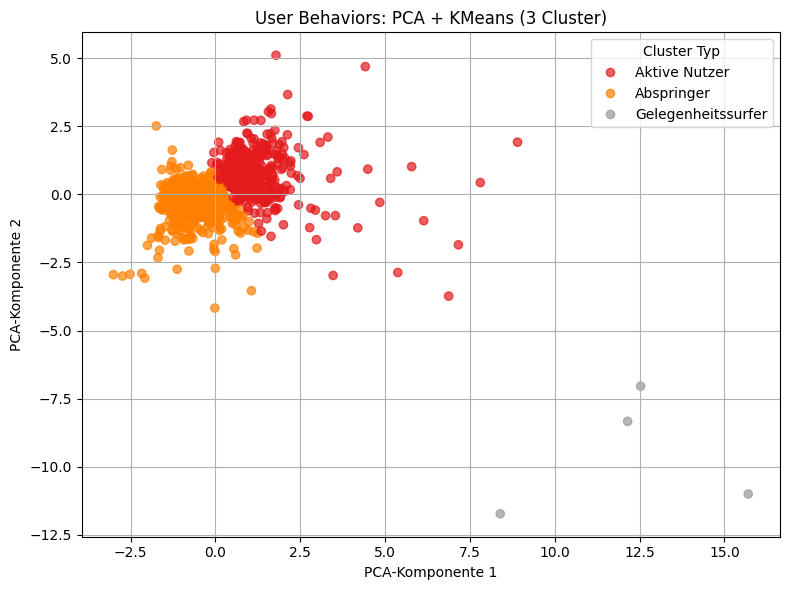

In [ ]:
# User Behaviors: PCA + KMeans
cluster_names = {0: "Aktive Nutzer", 1: "Abspringer", 2: "Gelegenheitssurfer"}

df_uv["cluster_name"] = df_uv["cluster"].map(cluster_names)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pcs[:, 0], pcs[:, 1], c=labels_uv, cmap="Set1", alpha=0.7)

# Farbwerte der Cluster-Labels extrahieren, um Legende mit Text zu erstellen
handles, _ = scatter.legend_elements()
plt.legend(
    handles, [cluster_names[i] for i in range(len(cluster_names))], title="Cluster Typ"
)

plt.title("User Behaviors: PCA + KMeans (3 Cluster)")
plt.xlabel("PCA‑Komponente 1")
plt.ylabel("PCA‑Komponente 2")
plt.grid(True)
plt.tight_layout()
plt.show()